In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def find_local_maxima(matrix):
    def is_local_maxima(matrix, i, j):
        rows, cols = matrix.shape
        value = matrix[i, j]
        if np.isnan(value):
            return False
        def is_valid_and_greater_than(value, neighbor):
            return not np.isnan(neighbor) and neighbor > value
        if i > 0 and is_valid_and_greater_than(value, matrix[i - 1, j]):
            return False
        if i < rows - 1 and is_valid_and_greater_than(value, matrix[i + 1, j]):
            return False
        if j > 0 and is_valid_and_greater_than(value, matrix[i, j - 1]):
            return False
        if j < cols - 1 and is_valid_and_greater_than(value, matrix[i, j + 1]):
            return False
        if i > 0 and j > 0 and is_valid_and_greater_than(value, matrix[i - 1, j - 1]):
            return False
        if i > 0 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i - 1, j + 1]):
            return False
        if i < rows - 1 and j > 0 and is_valid_and_greater_than(value, matrix[i + 1, j - 1]):
            return False
        if i < rows - 1 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i + 1, j + 1]):
            return False
        return True
    i_max, j_max, value_max = [], [], []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if is_local_maxima(matrix, i, j):
                i_max.append(i)
                j_max.append(j)
                value_max.append(matrix[i, j])
    return i_max, j_max, value_max

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def get_variable_name(var):
    for name, value in globals().items():
        if value is var:
            return name
    return None

def make_cartesian(lon, lat, theta0, phi0):
    lonr, latr = np.deg2rad(lon), np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(np.deg2rad(phi0)) * (lonr - np.deg2rad(theta0))
    y = r_earth * (latr - np.deg2rad(phi0))
    return x, y

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x/1000, y/1000

def rotate_30_clockwise(x, y):
    theta = np.deg2rad(30)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

def extract_contour(level_to_extract, plot):
    for level_paths in plot.allsegs:
        for path in level_paths:
            xt = path[:, 0]
            yt = path[:, 1]
            return xt, yt
    else:
        return [], []

In [4]:
edata = eddies['Eddy15'].iloc[10] #E22T5 #E17T3
t = extract_number(edata.name)

mcolor = 'r' if edata.Vort > 0 else 'c'
colormap = 'Reds' if edata.Vort > 0 else 'Blues'

temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:
    
    fnumber = '0'+str(round(1461+ file_idx*30))
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_'+fnumber+'.nc'
    dataset = nc.Dataset(fname)
    
    U = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
    V = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
    Vorticity = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_'+fnumber+'.npy')
    TemperatureAnomaly = np.load('/srv/scratch/z5297792/Climatology/temps/temp_'+fnumber+'.npy') - np.repeat(temp_ave[:, :, :, np.newaxis], 30, axis=3)
    CurSpeed = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy')
    CurSpeedAnomaly = CurSpeed - np.repeat(CurSpeed_ave[:, :, :, np.newaxis], 30, axis=3)
    OW = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_'+fnumber+'.npy')
    ocean_time = dataset.variables['ocean_time'][:]
    
    previous_file_idx = file_idx

In [5]:
from skimage.metrics import structural_similarity as ssim

def correlation_center_finder(grid1, grid2):
    def cycle_matrix(matrix, row_shift, col_shift):
        row_shift %= matrix.shape[0]
        col_shift %= matrix.shape[1]
        return np.roll(np.roll(matrix, row_shift, axis=0), col_shift, axis=1)

    def compare_matrices_ssim(matrix1, matrix2):
        data_range = matrix1.max() - matrix1.min()
        return ssim(matrix1, matrix2, data_range=data_range)

    def center_list(n):
        midpoint = n // 2
        return np.arange(-midpoint, n - midpoint)

    xs = center_list(grid1.shape[1])
    ys = center_list(grid1.shape[0])
    correlations = [
        (x, y, compare_matrices_ssim(grid1, cycle_matrix(grid2, y, x)))
        for x in xs for y in ys
    ]
    df = pd.DataFrame(correlations, columns=['Right', 'Up', 'Correlation'])
    best_shift = df.loc[df['Correlation'].idxmax()]

    return df, best_shift['Up'], best_shift['Right']

from shapely.geometry import Polygon
def calculate_centroid(xt, yt):
    if len(xt) == 0:
        return np.nan, np.nan
    polygon = Polygon(zip(xt, yt))
    centroid = polygon.centroid
    return centroid.x, centroid.y

def gaussian_vortex(a, b, i_shift, j_shift, amplitude=1, sigma=1):
    x = np.linspace(-1, 1, b)
    y = np.linspace(-1, 1, a)
    x, y = np.meshgrid(x, y)
    return amplitude * np.exp(-((x - j_shift)**2 + (y - i_shift)**2) / (2 * sigma**2))


/home/z5297792/.local/lib/python3.10/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/z5297792/.local/lib/python3.10/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


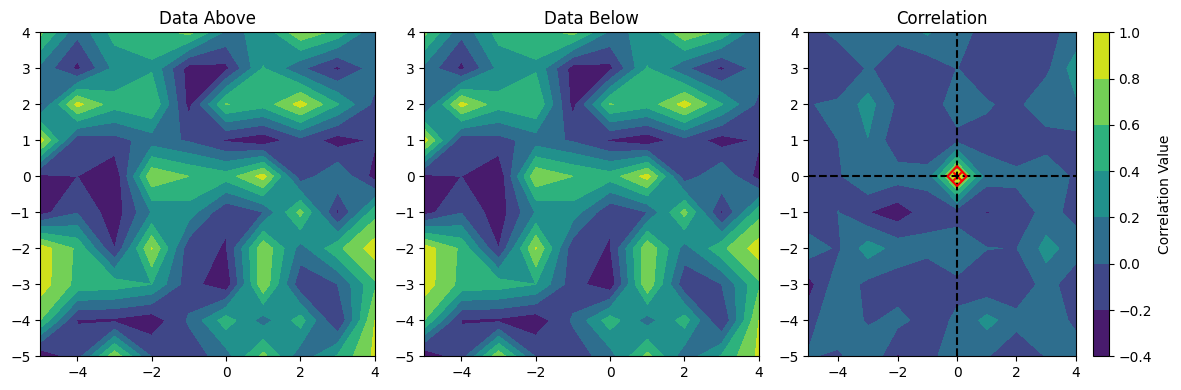

In [6]:
a, b = 10, 10
Data_abv = np.random.randint(0, 100, (10, 10))
Data_blw = Data_abv

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)

xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]


fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].quiver(0, 0, iR, iU, color='r')
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 
ax[2].contour(np.unique(df['Right']), np.unique(df['Up']), mat.T,levels=[.7], colors='r')

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')

# Display the plots
plt.tight_layout()
plt.show()

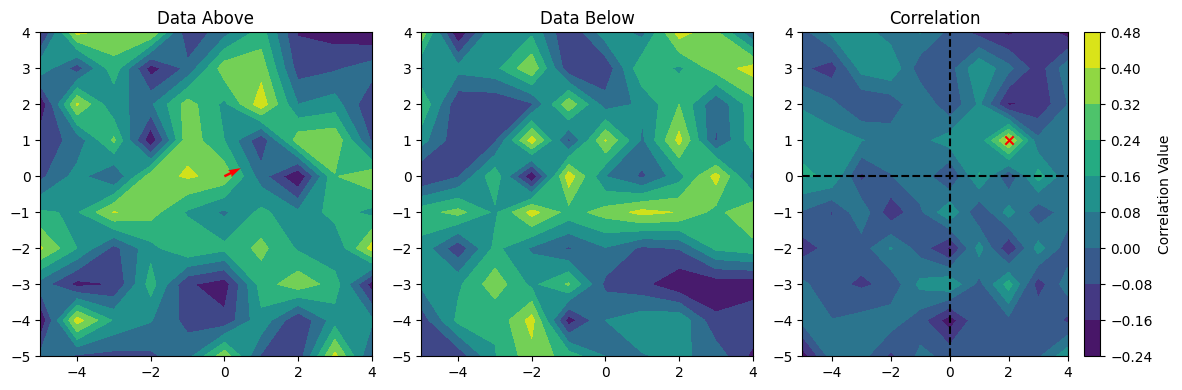

In [7]:
a, b = 10, 10
Data_abv = np.random.randint(0, 100, (10, 10))
Data_blw = np.random.randint(0, 100, (10, 10))

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)

xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]


fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].quiver(0, 0, iR, iU, color='r')
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 
ax[2].contour(np.unique(df['Right']), np.unique(df['Up']), mat.T,levels=[.7], colors='r')

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')

# Display the plots
plt.tight_layout()
plt.show()

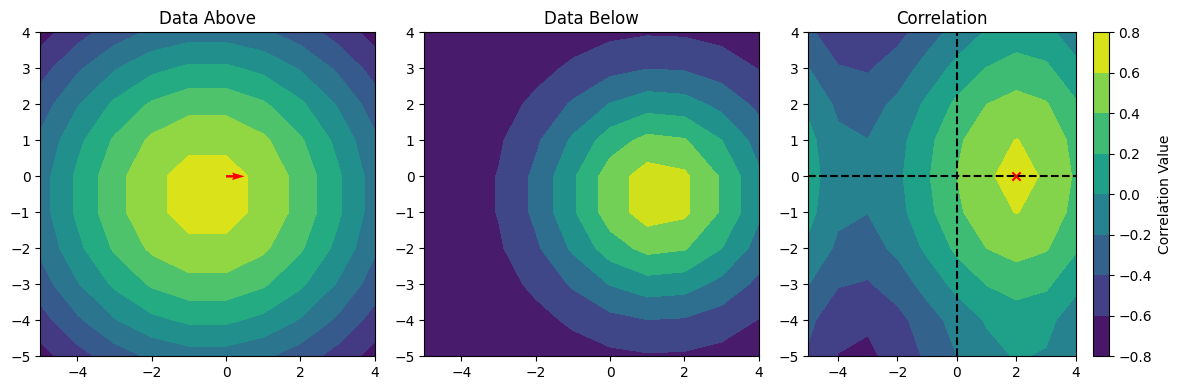

In [8]:
a, b = 10, 10
Data_abv = gaussian_vortex(a, b, 0, 0, amplitude=1, sigma=1)
Data_blw = gaussian_vortex(a, b, 0, .4, amplitude=1, sigma=.5)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].quiver(0, 0, iR, iU, color='r')
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 
ax[2].contour(np.unique(df['Right']), np.unique(df['Up']), mat.T,levels=[.7], colors='r')

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')


# Display the plots
plt.tight_layout()
plt.show()

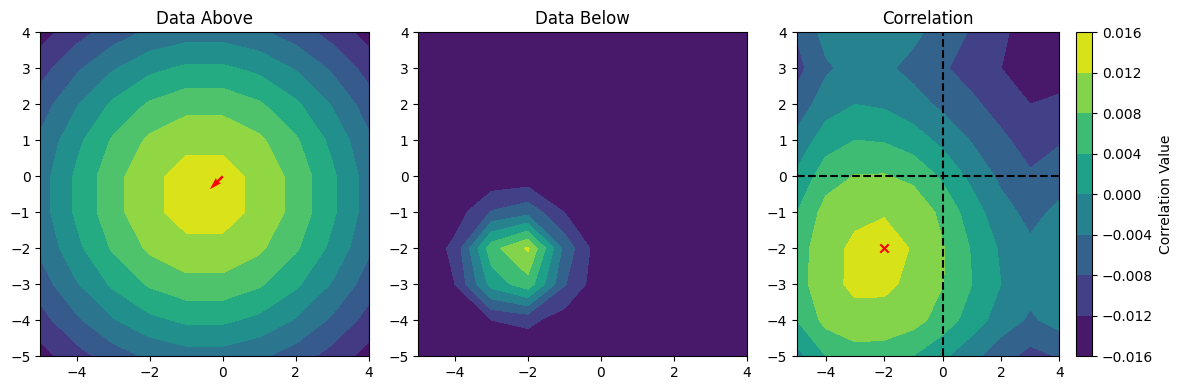

In [9]:
a, b = 10, 10
Data_abv = gaussian_vortex(a, b, 0, 0, amplitude=1, sigma=1)
Data_blw = gaussian_vortex(a, b, -.4, -.4, amplitude=.2, sigma=.2)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].quiver(0, 0, iR, iU, color='r')
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 
ax[2].contour(np.unique(df['Right']), np.unique(df['Up']), mat.T,levels=[.7], colors='r')

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')


# Display the plots
plt.tight_layout()
plt.show()

In [10]:
def annulus_vortex(a, b, inner_radius, outer_radius, i_shift, j_shift, amplitude=1, sigma=1):
    x = np.linspace(-1, 1, b)
    y = np.linspace(-1, 1, a)
    x, y = np.meshgrid(x, y)
    distance = np.sqrt((x - j_shift)**2 + (y - i_shift)**2)
    annulus = np.where((distance >= inner_radius) & (distance <= outer_radius),
                       amplitude * np.exp(-((distance)**2) / (2 * sigma**2)), 0)
    return annulus

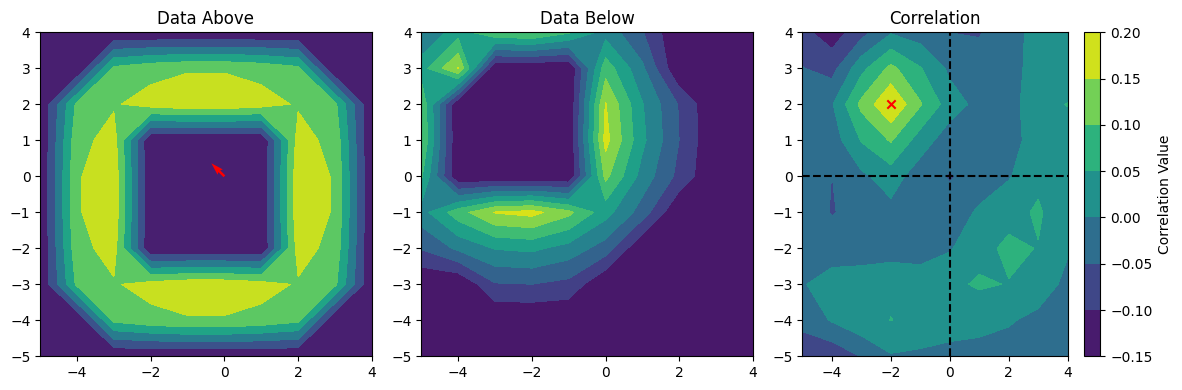

In [11]:
a, b = 10, 10
Data_abv = annulus_vortex(a, b, .5, 1, 0, 0, amplitude=1, sigma=1)
Data_blw = annulus_vortex(a, b, .5, 1, .4, -.4, amplitude=.5, sigma=.5)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].quiver(0, 0, iR, iU, color='r')
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 
ax[2].contour(np.unique(df['Right']), np.unique(df['Up']), mat.T,levels=[.7], colors='r')

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')


# Display the plots
plt.tight_layout()
plt.show()

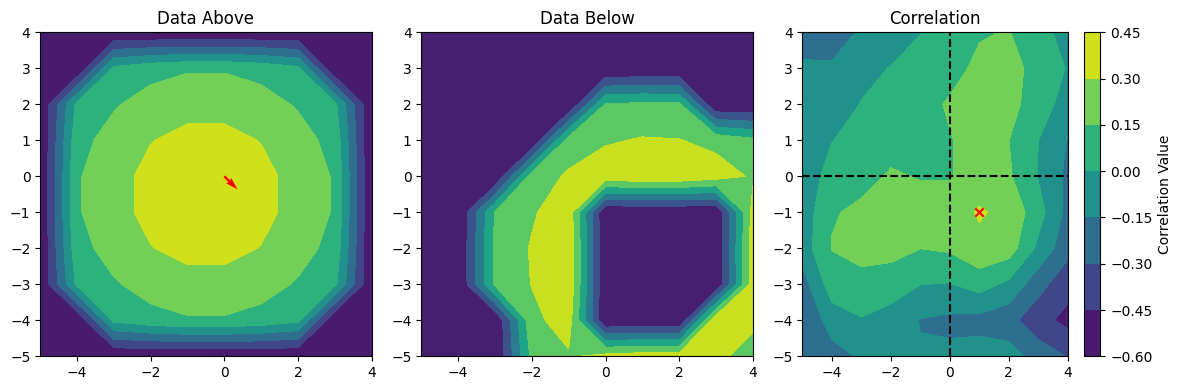

In [12]:
a, b = 10, 10
Data_abv = annulus_vortex(a, b, .1, 1, 0, 0, amplitude=1, sigma=1)
Data_blw = annulus_vortex(a, b, .5, 1, -.4, .4, amplitude=1, sigma=1)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].quiver(0, 0, iR, iU, color='r')
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')


# Display the plots
plt.tight_layout()
plt.show()

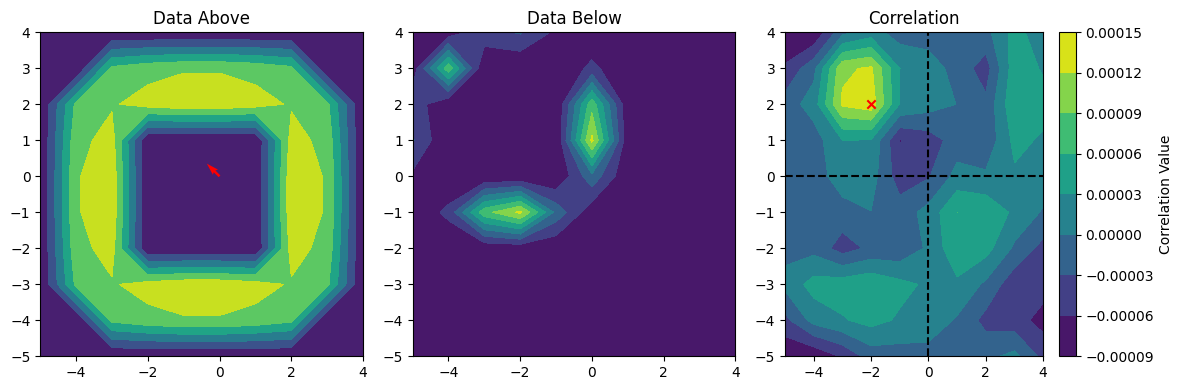

In [13]:
a, b = 10, 10
Data_abv = annulus_vortex(a, b, .5, 1, 0, 0, amplitude=1, sigma=1)
Data_blw = annulus_vortex(a, b, .5, 1, .4, -.4, amplitude=.5, sigma=.2)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].quiver(0, 0, iR, iU, color='r')
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 
ax[2].contour(np.unique(df['Right']), np.unique(df['Up']), mat.T,levels=[.7], colors='r')

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')


# Display the plots
plt.tight_layout()
plt.show()

# Modelled Eddy

In [14]:
def calculate_okubo_weis(uu, vv, dx, dy):

    WIDTH, LENGTH, SIGMAS = uu.shape

    # CHANGES IN VELOCITIES
    # For u_x
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    # For u_y
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    # For v_x
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    # For v_y
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)

    # For u_x
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    # For v_x
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    # For u_y
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    # For v_y
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    # NORMAL STRAIN
    s_n = u_x - v_y
    # SHEAR STRAIN
    s_s = v_x + u_y
    # VORTICITY
    vort = v_x - u_y
    # OKUBO-WEISS
    ow = s_n**2 + s_s**2 - vort**2

    return ow

def normalize_matrix(LOW):
    ocean_mask = np.where(np.isnan(LOW), np.zeros_like(LOW), 1)
    OW_mean = np.nansum(LOW) / np.sum(ocean_mask)
    OW_std = np.sqrt(np.nansum(ocean_mask * (LOW - OW_mean) ** 2) / np.sum(ocean_mask))
    return LOW / OW_std

## No Tilt

In [15]:
# Constants
f0 = 2 * 7.29E-5 * np.sin(np.radians(-40))  # Coriolis parameter
g = 9.81  # Gravitational acceleration
rho0 = 1025  # Assumed reference density (kg/m^3)
a = 1  # Linear coefficient for stratification
b = 1  # Exponential coefficient
L = 1e5  # Horizontal scale
H = 1200  # Depth scale
eta0 = 1  # Surface elevation perturbation

WIDTH = 500000  # Horizontal extent of the grid (eddy scale)
DEPTH_LAYERS = 10  # Number of depth levels

# Create 2D meshgrid for horizontal space (x, y) and depth (z)
y = np.linspace(-WIDTH//2, WIDTH//2, 100)  # y-coordinates
x = np.linspace(-WIDTH//2, WIDTH//2, 100)  # x-coordinates
z = np.linspace(-H, 0, DEPTH_LAYERS)  # Depth levels from surface (0) to -H

# Create 3D meshgrid
x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

# Calculate radial distance r
r = np.sqrt(x_3d**2 + y_3d**2)

# Calculate density anomaly sigma (stratification effect in eddy)
sigma = rho0 - a * z_3d + b * np.exp(-r**2 / L**2) * np.exp(z_3d / H)

# Calculate 3D geostrophic velocity components for an eddy
U = 2 * g * y_3d / (f0 * L**2) * (b * H / rho0 * (1 - np.exp(z_3d / H)) - eta0) * np.exp(-r**2 / L**2)
V = - 2 * g * x_3d / (f0 * L**2) * (b * H / rho0 * (1 - np.exp(z_3d / H)) - eta0) * np.exp(-r**2 / L**2)
CS = np.sqrt(U**2 + V**2)


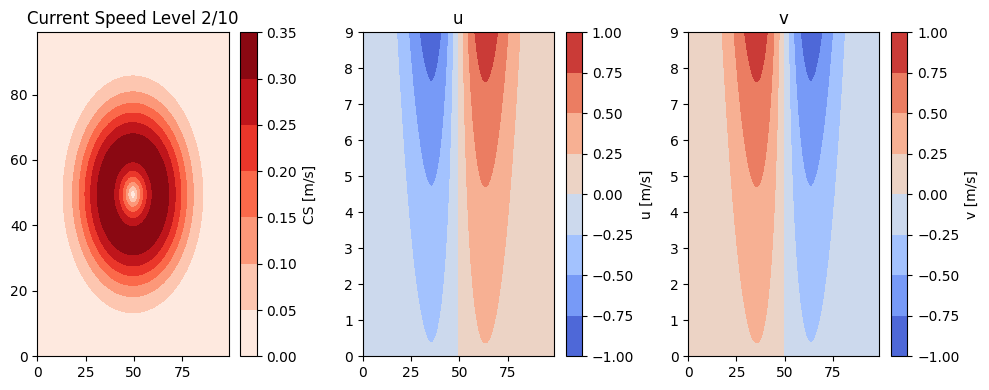

In [16]:
DEPTH_LVL = 2
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
c = axs[0].contourf(CS[:,:,DEPTH_LVL], cmap='Reds')
fig.colorbar(c, ax=axs[0], label='CS [m/s]')
axs[0].set_title('Current Speed Level '+str(DEPTH_LVL)+'/'+str(U.shape[-1]))
contour_u = axs[1].contourf(U[U.shape[0]//2,:,:].T, cmap='coolwarm')
fig.colorbar(contour_u, ax=axs[1], label='u [m/s]')
axs[1].set_title('u')
contour_v = axs[2].contourf(V[:,V.shape[1]//2,:].T, cmap='coolwarm')
fig.colorbar(contour_v, ax=axs[2], label='v [m/s]')
axs[2].set_title('v')
plt.tight_layout()
plt.show()

/home/z5297792/.local/lib/python3.10/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/z5297792/.local/lib/python3.10/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


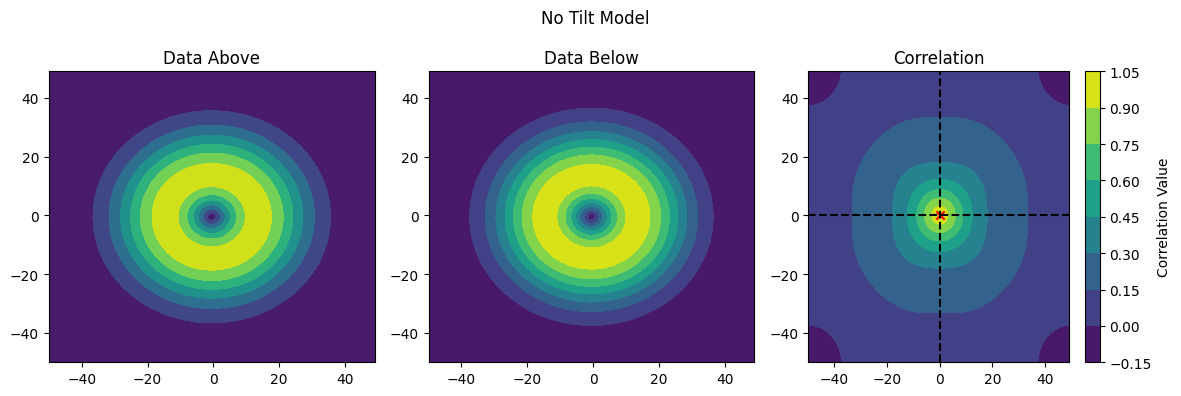

In [17]:
DEPTH_LVL = 5

Data_abv = CS[:, :, DEPTH_LVL]
Data_blw = CS[:, :, DEPTH_LVL + 1]

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].quiver(0, 0, iR, iU, color='r')
ax[0].set_title('Data Above')

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r')
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')

fig.suptitle('No Tilt Model')

plt.tight_layout()
plt.show()

## Tilt

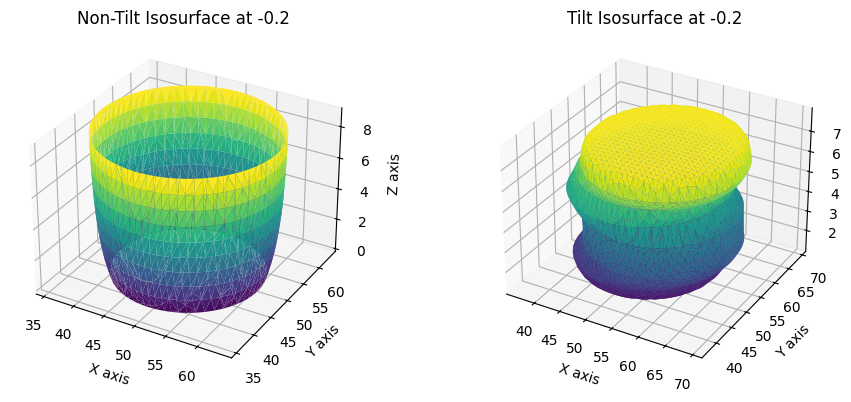

In [18]:
def random_shift_3d_matrix_relative(matrix, R):
    # Get the dimensions of the matrix
    x, y, z = matrix.shape
    
    # Create a new matrix to store the shifted values
    shifted_matrix = np.zeros_like(matrix)
    
    # Initialize previous shift values
    prev_shift_y = 0
    prev_shift_x = 0

    x_shift_cpy = []
    y_shift_cpy = []
    
    # Iterate through each layer in the z-dimension
    for layer in range(z):
        # Generate random horizontal and vertical shifts within the range of [-R, R]
        shift_y = np.random.randint(-R, R + 1)  # Vertical shift (up/down)
        shift_x = np.random.randint(-R, R + 1)  # Horizontal shift (left/right)
        
        # Calculate effective shifts considering the previous layer's shifts
        effective_shift_y = shift_y + prev_shift_y
        effective_shift_x = shift_x + prev_shift_x
        
        # Shift the layer and fill with zeros where necessary
        if effective_shift_y > 0:  # Shift down
            if effective_shift_x > 0:  # Shift down and right
                shifted_matrix[effective_shift_y:, effective_shift_x:, layer] = matrix[:-effective_shift_y, :-effective_shift_x, layer]
                shifted_matrix[:effective_shift_y, effective_shift_x:, layer] = 0  # Fill the new values with zeros
                shifted_matrix[effective_shift_y:, :effective_shift_x, layer] = 0
            elif effective_shift_x < 0:  # Shift down and left
                shifted_matrix[effective_shift_y:, :effective_shift_x, layer] = matrix[:-effective_shift_y, -effective_shift_x:, layer]
                shifted_matrix[:effective_shift_y, :effective_shift_x, layer] = 0  # Fill the new values with zeros
                shifted_matrix[effective_shift_y:, -effective_shift_x:, layer] = 0
            else:  # Shift down only
                shifted_matrix[effective_shift_y:, :, layer] = matrix[:-effective_shift_y, :, layer]
                shifted_matrix[:effective_shift_y, :, layer] = 0  # Fill the new values with zeros
        elif effective_shift_y < 0:  # Shift up
            if effective_shift_x > 0:  # Shift up and right
                shifted_matrix[:effective_shift_y, effective_shift_x:, layer] = matrix[-effective_shift_y:, :-effective_shift_x, layer]
                shifted_matrix[-effective_shift_y:, effective_shift_x:, layer] = 0  # Fill the new values with zeros
                shifted_matrix[:effective_shift_y, :effective_shift_x, layer] = 0
            elif effective_shift_x < 0:  # Shift up and left
                shifted_matrix[:effective_shift_y, :effective_shift_x, layer] = matrix[-effective_shift_y:, -effective_shift_x:, layer]
                shifted_matrix[-effective_shift_y:, :effective_shift_x, layer] = 0  # Fill the new values with zeros
                shifted_matrix[:effective_shift_y, -effective_shift_x:, layer] = 0
            else:  # Shift up only
                shifted_matrix[:effective_shift_y, :, layer] = matrix[-effective_shift_y:, :, layer]
                shifted_matrix[-effective_shift_y:, :, layer] = 0  # Fill the new values with zeros
        else:  # No vertical shift
            if effective_shift_x > 0:  # Shift right only
                shifted_matrix[:, effective_shift_x:, layer] = matrix[:, :-effective_shift_x, layer]
                shifted_matrix[:, :effective_shift_x, layer] = 0  # Fill the new values with zeros
            elif effective_shift_x < 0:  # Shift left only
                shifted_matrix[:, :effective_shift_x, layer] = matrix[:, -effective_shift_x:, layer]
                shifted_matrix[:, effective_shift_x:, layer] = 0  # Fill the new values with zeros
            else:  # No shift
                shifted_matrix[:, :, layer] = matrix[:, :, layer]

        # Update previous shifts for the next layer
        prev_shift_y = effective_shift_y
        prev_shift_x = effective_shift_x

        x_shift_cpy.append(effective_shift_x)
        y_shift_cpy.append(effective_shift_y)

    shift_id = pd.DataFrame({
        'x': x_shift_cpy,
        'y': y_shift_cpy
    })

    return shifted_matrix, shift_id

def copy_shift(matrix, shift_id):
    
    # Get the dimensions of the matrix
    x, y, z = matrix.shape
    
    # Create a new matrix to store the shifted values
    shifted_matrix = np.zeros_like(matrix)
    # Iterate through each layer in the z-dimension
    for layer in range(z):

        # Calculate effective shifts considering the previous layer's shifts
        effective_shift_y = shift_id.iloc[layer].y
        effective_shift_x = shift_id.iloc[layer].x
        
        # Shift the layer and fill with zeros where necessary
        if effective_shift_y > 0:  # Shift down
            if effective_shift_x > 0:  # Shift down and right
                shifted_matrix[effective_shift_y:, effective_shift_x:, layer] = matrix[:-effective_shift_y, :-effective_shift_x, layer]
                shifted_matrix[:effective_shift_y, effective_shift_x:, layer] = 0  # Fill the new values with zeros
                shifted_matrix[effective_shift_y:, :effective_shift_x, layer] = 0
            elif effective_shift_x < 0:  # Shift down and left
                shifted_matrix[effective_shift_y:, :effective_shift_x, layer] = matrix[:-effective_shift_y, -effective_shift_x:, layer]
                shifted_matrix[:effective_shift_y, :effective_shift_x, layer] = 0  # Fill the new values with zeros
                shifted_matrix[effective_shift_y:, -effective_shift_x:, layer] = 0
            else:  # Shift down only
                shifted_matrix[effective_shift_y:, :, layer] = matrix[:-effective_shift_y, :, layer]
                shifted_matrix[:effective_shift_y, :, layer] = 0  # Fill the new values with zeros
        elif effective_shift_y < 0:  # Shift up
            if effective_shift_x > 0:  # Shift up and right
                shifted_matrix[:effective_shift_y, effective_shift_x:, layer] = matrix[-effective_shift_y:, :-effective_shift_x, layer]
                shifted_matrix[-effective_shift_y:, effective_shift_x:, layer] = 0  # Fill the new values with zeros
                shifted_matrix[:effective_shift_y, :effective_shift_x, layer] = 0
            elif effective_shift_x < 0:  # Shift up and left
                shifted_matrix[:effective_shift_y, :effective_shift_x, layer] = matrix[-effective_shift_y:, -effective_shift_x:, layer]
                shifted_matrix[-effective_shift_y:, :effective_shift_x, layer] = 0  # Fill the new values with zeros
                shifted_matrix[:effective_shift_y, -effective_shift_x:, layer] = 0
            else:  # Shift up only
                shifted_matrix[:effective_shift_y, :, layer] = matrix[-effective_shift_y:, :, layer]
                shifted_matrix[-effective_shift_y:, :, layer] = 0  # Fill the new values with zeros
        else:  # No vertical shift
            if effective_shift_x > 0:  # Shift right only
                shifted_matrix[:, effective_shift_x:, layer] = matrix[:, :-effective_shift_x, layer]
                shifted_matrix[:, :effective_shift_x, layer] = 0  # Fill the new values with zeros
            elif effective_shift_x < 0:  # Shift left only
                shifted_matrix[:, :effective_shift_x, layer] = matrix[:, -effective_shift_x:, layer]
                shifted_matrix[:, effective_shift_x:, layer] = 0  # Fill the new values with zeros
            else:  # No shift
                shifted_matrix[:, :, layer] = matrix[:, :, layer]

    return shifted_matrix

R = 3

U_shifted, shift_id = random_shift_3d_matrix_relative(U, R)

V_shifted = copy_shift(V, shift_id)

CS_shifted = copy_shift(CS, shift_id)

ow = calculate_okubo_weis(U, V, x[1]-x[0], y[1]-y[0])
ow = normalize_matrix(ow)
ow_shifted = calculate_okubo_weis(U_shifted, V_shifted, x[1]-x[0], y[1]-y[0])
ow_shifted = normalize_matrix(ow_shifted)

from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

fig = plt.figure(figsize=(10, 4))

# Non-Tilt Isosurface
ax1 = fig.add_subplot(121, projection='3d')
X, Y, Z = np.meshgrid(x, y, z)
verts, faces, _, _ = measure.marching_cubes(ow, -0.2)
ax1.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, cmap='viridis', lw=1)
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('Z axis')
ax1.set_title('Non-Tilt Isosurface at -0.2')

# Tilt Isosurface
ax2 = fig.add_subplot(122, projection='3d')
verts, faces, _, _ = measure.marching_cubes(ow_shifted, -0.2)
ax2.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, cmap='viridis', lw=1)
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')
ax2.set_zlabel('Z axis')
ax2.set_title('Tilt Isosurface at -0.2')

plt.tight_layout()
plt.show()


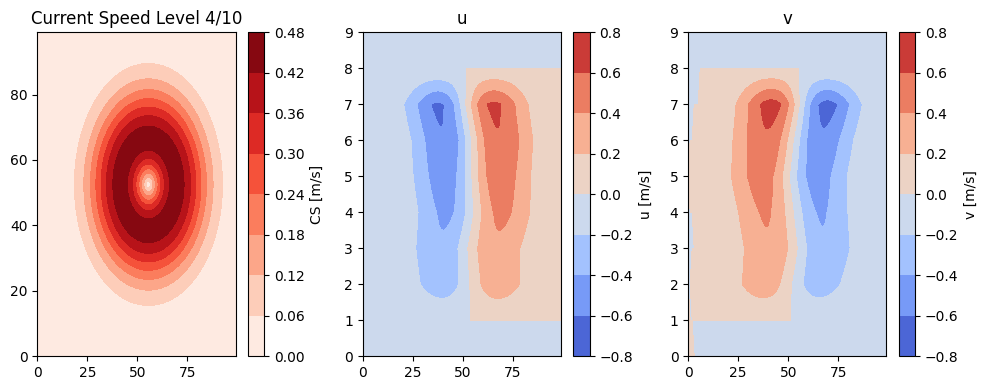

In [19]:
DEPTH_LVL = 4
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
c = axs[0].contourf(CS_shifted[:,:,DEPTH_LVL], cmap='Reds')
fig.colorbar(c, ax=axs[0], label='CS [m/s]')
axs[0].set_title('Current Speed Level '+str(DEPTH_LVL)+'/'+str(U.shape[-1]))
contour_u = axs[1].contourf(U_shifted[U_shifted.shape[0]//2,:,:].T, cmap='coolwarm')
fig.colorbar(contour_u, ax=axs[1], label='u [m/s]')
axs[1].set_title('u')
contour_v = axs[2].contourf(V_shifted[:,V_shifted.shape[1]//2,:].T, cmap='coolwarm')
fig.colorbar(contour_v, ax=axs[2], label='v [m/s]')
axs[2].set_title('v')
plt.tight_layout()
plt.show()

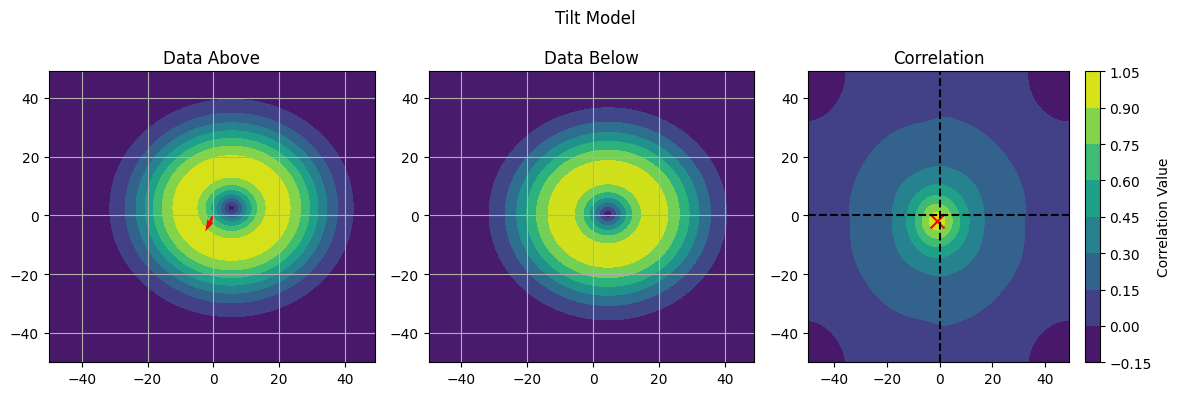

In [20]:
DEPTH_LVL = 4

Data_abv = CS_shifted[:, :, DEPTH_LVL]
Data_blw = CS_shifted[:, :, DEPTH_LVL + 1]

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
xs, ys, values = df.Right, df.Up, df.Correlation
mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
for i in np.unique(xs):
    for j in np.unique(ys):
        mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
ax[0].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].quiver(0, 0, iR, iU, color='r')
ax[0].set_title('Data Above')
ax[0].grid(True)

# Second subplot
ax[1].contourf(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')
ax[1].grid(True)

# Third subplot
contour3 = ax[2].contourf(np.unique(df['Right']), np.unique(df['Up']), mat.T)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r', s=100)
ax[2].axvline(x=0, color='k', linestyle='--')  
ax[2].axhline(y=0, color='k', linestyle='--') 

cbar = fig.colorbar(contour3, ax=ax[2])
cbar.set_label('Correlation Value')

fig.suptitle('Tilt Model')

plt.tight_layout()
plt.show()

## MOCA TEST

In [21]:
U1 = U_shifted

V1 = V_shifted 

CS1 = CS_shifted 

In [22]:
def polynomial_fit_with_error(x, y, degree=1):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]
    if degree not in [0, 1]:
        raise ValueError("Degree must be 0 or 1.")
    coefficients, cov = np.polyfit(x, y, degree, cov=True)  # coefficients = [slope, intercept]
    y_fit = np.polyval(coefficients, x)
    residuals = y - y_fit
    std_err_coeffs = np.sqrt(np.diag(cov))
    ss_total = np.sum((y - np.mean(y))**2)
    ss_residuals = np.sum(residuals**2)
    r_squared = 1 - (ss_residuals / ss_total)
    return coefficients, std_err_coeffs, r_squared

def haversine_distance(lat1, lon1, bearing, distance):
    R = 6371000
    lat1, lon1, bearing = map(math.radians, [lat1, lon1, bearing])

    lat2 = math.asin(math.sin(lat1) * math.cos(distance / R) +
                     math.cos(lat1) * math.sin(distance / R) * math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(distance / R) * math.cos(lat1),
                             math.cos(distance / R) - math.sin(lat1) * math.sin(lat2))

    return math.degrees(lat2), math.degrees(lon2)

def true_bearing(x, y):
    angle_radians = math.atan2(y, x)
    angle_degrees = math.degrees(angle_radians)
    bearing = (90 - angle_degrees) % 360
    return bearing

def is_pos_def(Q):
    eigenvalues = np.linalg.eigvals(Q)
    return np.all(eigenvalues > 0)


In [23]:
SEARCH_WIDTH = 100000
DEPTH_LVL_LIMIT = 23

i_left = 40
i_right = 60
j_down = 40
j_up = 60

xx = x[i_left:i_right]
yy = y[j_down:j_up]

depth_dics3 = {}
for depth_lvl in range(U1.shape[2]):
    u1 = U1[i_left:i_right, U1.shape[1]//2, depth_lvl]
    v1 = V1[i_left:i_right, V1.shape[1]//2,depth_lvl]
    u2 = U1[U1.shape[0]//2, j_down:j_up, depth_lvl]
    v2 = V1[V1.shape[0]//2, j_down:j_up, depth_lvl]
    As, dAs, r2A = polynomial_fit_with_error(xx, u1, degree=1)
    A1, A0 = As
    Bs, dBs, r2B = polynomial_fit_with_error(xx, v1, degree=1)
    B1, B0 = Bs
    Cs, dCs, r2C = polynomial_fit_with_error(yy, u2, degree=1)
    C1, C0 = Cs
    Ds, DAs, r2D = polynomial_fit_with_error(yy, v2, degree=1)
    D1, D0 = Ds
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    Q = np.array([[q11, q12], [q12, q22]])
    if is_pos_def(Q) or is_pos_def(-Q):
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))
    else:
        xc = yc = np.nan
    depth_dics3[f'Depth{depth_lvl}'] = {
        'dfx': pd.DataFrame({'x': xx, 'u1': u1, 'v1': v1}),
        'dfy': pd.DataFrame({'y': yy, 'u2': u2, 'v2': v2}),
        'q11': q11, 'q12': q12, 'q22': q22,
        'xc': xc, 'yc': yc, 
        'Depth': z[depth_lvl]
    }


/scratch/pbs.5776034.kman.restech.unsw.edu.au/ipykernel_3685589/1179316806.py:12: RuntimeWarning: invalid value encountered in scalar divide
  r_squared = 1 - (ss_residuals / ss_total)


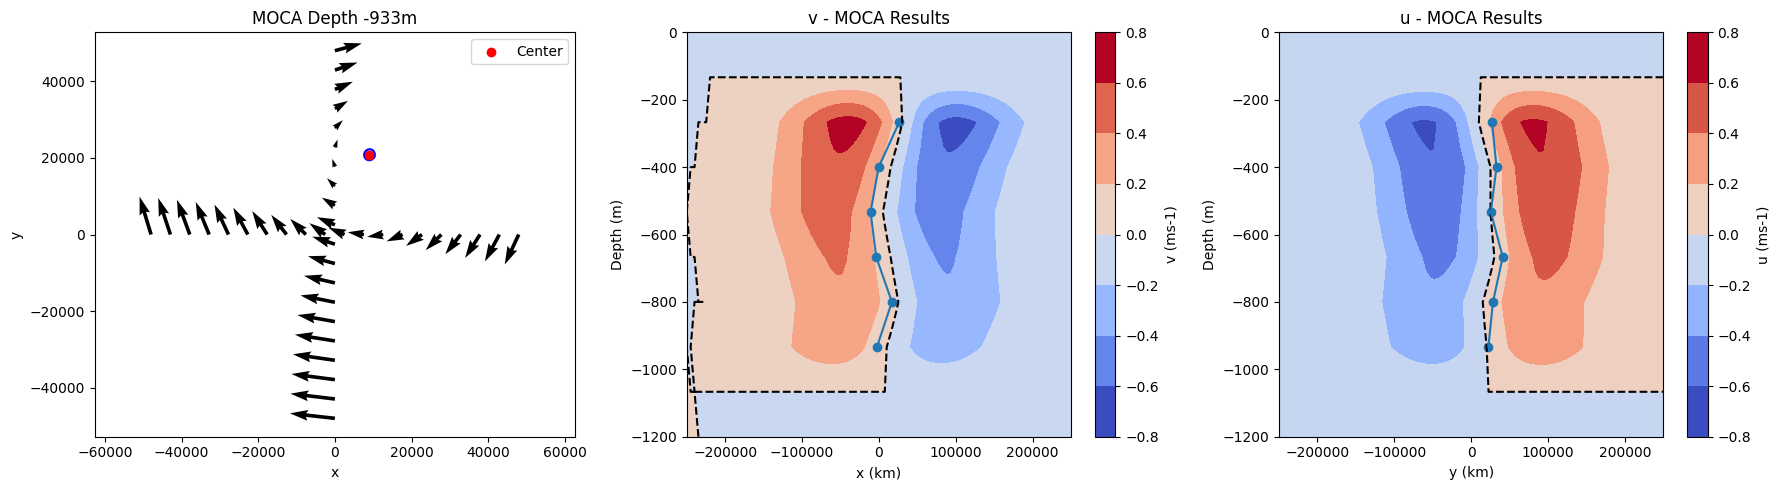

In [24]:
depth_lvl = 'Depth2'

dfx = depth_dics3[depth_lvl]['dfx']
dfy = depth_dics3[depth_lvl]['dfy']
x1, y1 = dfx.x, [0] * len(dfx.x)
x2, y2 = [0] * len(dfy.y), dfy.y
u1, v1 = dfx.u1, dfx.v1
u2, v2 = dfy.u2, dfy.v2

q11, q12, q22 = depth_dics3[depth_lvl]['q11'], depth_dics3[depth_lvl]['q12'], depth_dics3[depth_lvl]['q22']
xc_lvl, yc_lvl = depth_dics3[depth_lvl]['xc'], depth_dics3[depth_lvl]['yc']
depth = depth_dics3[depth_lvl]['Depth']
s = 5.991

Q = np.array([[q11, q12], [q12, q22]])
if not is_pos_def(Q):
    Q = -Q

num_points = 100
theta = np.linspace(0, 2 * np.pi, num_points)
ellipse = np.array([np.cos(theta), np.sin(theta)])
eigvals, eigvecs = np.linalg.eig(Q)
# if np.any(eigvals <= 0):
#     raise ValueError(f"Matrix Q is not positive definite. Eigenvalues: {eigvals}")

axes = np.sqrt(s / eigvals)
ellipse_transformed = eigvecs @ np.diag(axes) @ ellipse
ellipse_transformed += np.array([[xc_lvl], [yc_lvl]])

DISPLAY_WIDTH = 200000

xc_raw, yc_raw, zc = [], [], []
for depth_dic in depth_dics3.values():
    xc_raw.append(depth_dic['xc'])
    yc_raw.append(depth_dic['yc'])
    zc.append(depth_dic['Depth'])
# xc, yc = rotate_30_clockwise(xc_raw, yc_raw)
xc, yc = xc_raw, yc_raw

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# First subplot
axs[0].quiver(x1, y1, u1, v1)
axs[0].quiver(x2, y2, u2, v2)
axs[0].fill(ellipse_transformed[0], ellipse_transformed[1], color='lightblue', alpha=0.5)
axs[0].plot(ellipse_transformed[0], ellipse_transformed[1], color='blue')
axs[0].scatter([xc_lvl], [yc_lvl], color='red', zorder=5, label='Center')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend()
axs[0].set_title(f'MOCA Depth {depth:.0f}m')
axs[0].axis('equal')

# Second subplot
v_cross = V1[:, V1.shape[1]//2, :]
v_data_range = np.nanmax(np.abs(v_cross))
X, Z = np.meshgrid(x, z)
c1 = axs[1].contourf(X, Z, v_cross.T, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)
c1_contour = axs[1].contour(X, Z, v_cross.T, levels=[0], colors='black', linestyles='--')
axs[1].set_xlabel('x (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('v - MOCA Results')
axs[1].plot(xc, zc, '-', linewidth=1.5)
axs[1].scatter(xc, zc)
fig.colorbar(c1, ax=axs[1], label='v (ms-1)')

# Third subplot
u_cross = U1[U1.shape[0]//2, :, :]
u_data_range = np.nanmax(np.abs(u_cross))
Y, Z = np.meshgrid(y, z)
c2 = axs[2].contourf(Y, Z, u_cross.T, cmap='coolwarm', vmin=-u_data_range, vmax=u_data_range)
c2_contour = axs[2].contour(Y, Z, u_cross.T, levels=[0], colors='black', linestyles='--')
axs[2].set_xlabel('y (km)')
axs[2].set_ylabel('Depth (m)')
axs[2].set_title('u - MOCA Results')
axs[2].plot(yc, zc, '-', linewidth=1.5)
axs[2].scatter(yc, zc)
fig.colorbar(c2, ax=axs[2], label='u (ms-1)')

plt.tight_layout()
plt.show()


In [25]:
x.shape

(100,)